In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

In [24]:
def getGrid(n=1000, rim=0.1):
    """generate quadratic gridover unit square plus rim"""
    nx, ny= (n, n)
    x = np.linspace(-rim, 1+rim, nx)
    y = np.linspace(-rim, 1+rim, ny)
    xv, yv = np.meshgrid(x, y)
    return np.array([a for a in zip(xv.flat, yv.flat)])


def evaluate(dir_path="231204144400", phase="1"):
    # load data
    data = torch.load("./results/{}/data{}.pt".format(dir_path, phase))
    print(data.shape)

    # load model
    model = HumanModel().cuda()
    model.load_state_dict(torch.load("./results/{}/II-{}/HM_weights_II-{}.pt".format(dir_path, phase, phase)))
    model.eval()

    # predict all points
    num_classes = 10
    G = getGrid()

    model.eval()
    pred = model(torch.from_numpy(G).float().cuda())
    pred = torch.argmax(pred, axis=1).detach().cpu().numpy()

    # plot prediction and training data
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    for i in range(num_classes):
        s = G[pred==i]
        ax.plot(s[:,0], s[:,1], ".", ms=6, color=sn.color_palette("hls", 10)[i])
    plt.gca().set_prop_cycle(None)

    for i in range(num_classes):
        s = data[data[:,2]==i]
        ax.plot(s[:,0], s[:,1], "o", ms=3, markeredgecolor='black', markeredgewidth=1, color=sn.color_palette("hls", 10)[i])

    plt.title("HM {} - learned decision boundaries on user-defined data".format(phase))
    plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
    plt.show()


def draw_metrics(dir_path="231204144400", phase="1"):
    train_losses = torch.load("./results/{}/II-{}/train_losses_II-{}.pt".format(dir_path, phase, phase))
    test_losses = torch.load("./results/{}/II-{}/test_losses_II-{}.pt".format(dir_path, phase, phase))
    test_acc = torch.load("./results/{}/II-{}/test_acc_II-{}.pt".format(dir_path, phase, phase))

    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.legend(["train loss", "test loss"])

    plt.subplot(1,2,2)
    plt.plot(test_acc)
    plt.legend(["test acc"])

    plt.suptitle("HM-{} learning curves".format(phase))

    plt.show()

In [113]:
def get_acc(model, dataloader):
    model.eval()

    y_preds = []
    y_trues = []

    for data, label in tqdm(dataloader):
        pred = model(data.cuda())

        y_pred = torch.argmax(pred.detach().cpu(), dim=1).numpy()
        y_true = torch.argmax(label.detach().cpu(), dim=1).numpy()

        y_preds.append(y_pred)
        y_trues.append(y_true)
        
    acc = sklearn.metrics.accuracy_score(y_true=np.hstack(y_trues), y_pred=np.hstack(y_preds))

    return acc


def getGrid(n=1000, rim=0.1):
        """generate quadratic gridover unit square plus rim"""
        nx, ny= (n, n)
        x = np.linspace(-rim, 1+rim, nx)
        y = np.linspace(-rim, 1+rim, ny)
        xv,yv = np.meshgrid(x, y)
        return np.array([a for a in zip(xv.flat, yv.flat)])


def draw_decision(z_train, z_test, y_train, y_test, train=True, model_path="./results/231204144400/II-1/HM_weights_II-1.pt"):
    model = HumanModel().cuda()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # print accuracy
    train_dataset = torch.utils.data.TensorDataset(z_train, F.one_hot(y_train.long()).float())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(z_test, F.one_hot(y_test.long()).float())
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

    train_acc = get_acc(model, train_loader)
    test_acc = get_acc(model, test_loader)
    print("train acc: {}, test acc: {}".format(train_acc, test_acc))


    # predict all pixels
    num_classes = 10

    G = getGrid()

    model.eval()
    pred = model(torch.from_numpy(G).float().cuda())
    pred = torch.argmax(pred, axis=1).detach().cpu().numpy()

    # plot prediction and training data
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

    for i in range(num_classes):
        s = G[pred==i]
        ax.plot(s[:,0], s[:,1], ".", ms=6, color=sn.color_palette("Spectral", 10)[i])
    plt.gca().set_prop_cycle(None)

    for i in range(num_classes):
        if train==True:
            s = z_train[y_train==i]
        else:
            s = z_test[y_test==i]
        ax.plot(s[:,0], s[:,1], "o", ms=3, markeredgecolor='black', markeredgewidth=1, color=sn.color_palette("Spectral", 10)[i])

    train_test = "train" if train==True else "test"
    plt.title("[{} acc: {}] MLP: z -> y".format(train_test, train_acc))
    plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
    plt.show()

In [36]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image


# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# # sample
# idx = np.random.choice(np.arange(len(trainset)), size=10000)
# trainset = [trainset[i] for i in idx]
# idx = np.random.choice(np.arange(len(testset)), size=10000)
# testset = [testset[i] for i in idx]

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

print(len(train_dataset), len(test_dataset))

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000])
60000 10000


# 20231204

torch.Size([59706, 3])


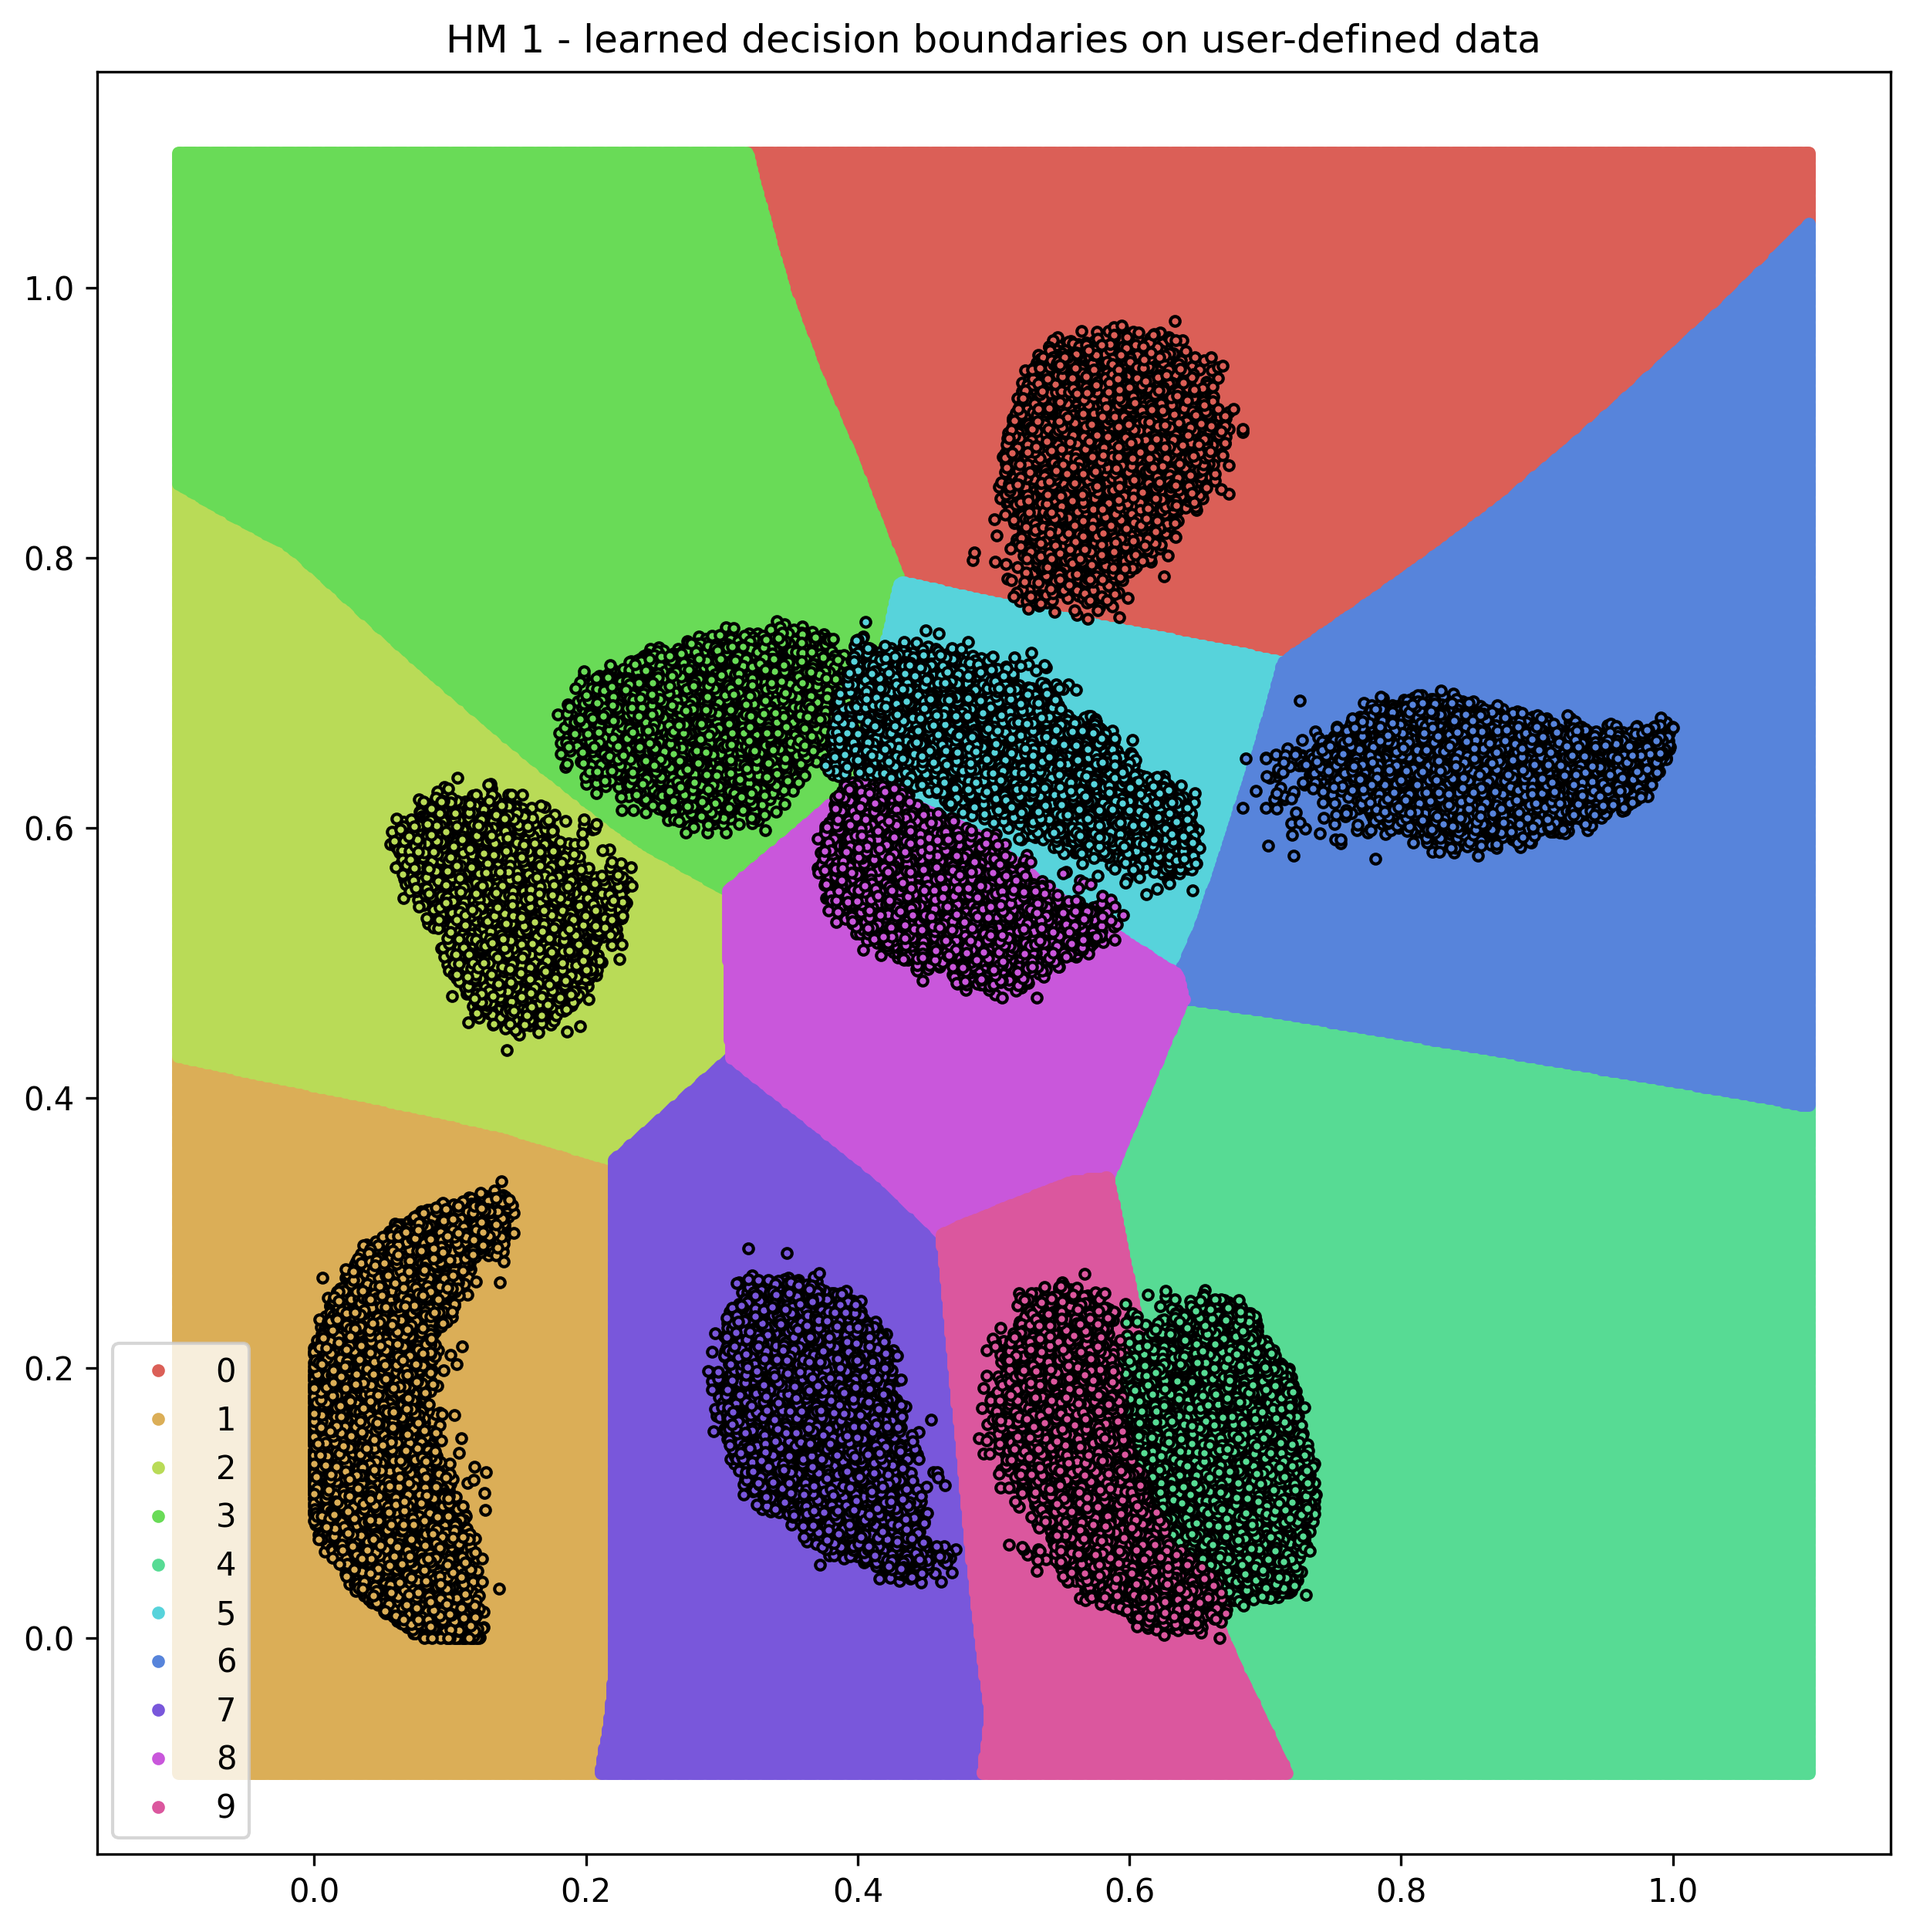

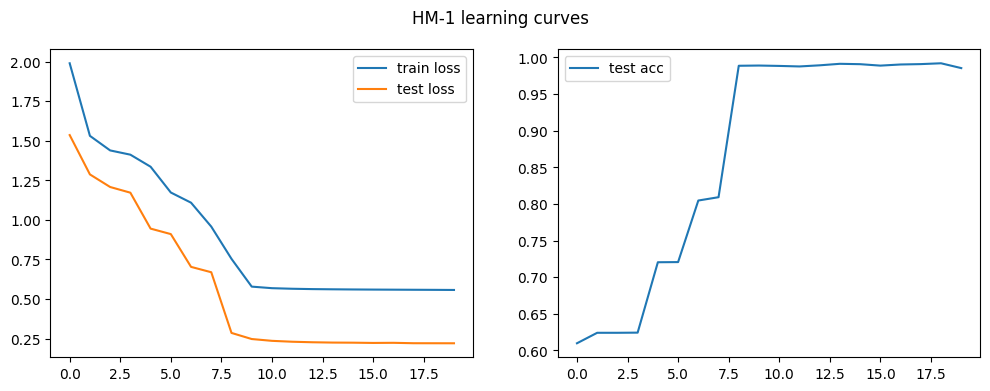

In [25]:
dir_path = "231204144400"
phase = "1"

evaluate(dir_path=dir_path, phase=phase)
draw_metrics(dir_path=dir_path, phase=phase)

In [67]:
model = Encoder().cuda()
model.load_state_dict(torch.load("./results/231204144400/I-1/DR_weights_best.pt"))
model.eval()

Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=2, bias=True)
)

In [104]:
Z_train = []
for data, label in train_loader:
    z = model(data.cuda()).view(-1,2)
    Z_train.append(z)

Z_train = torch.vstack(Z_train)
z_train = normalise(Z_train.detach().cpu())
z_train.shape

torch.Size([60000, 2])

In [105]:
Z_test = []
for data, label in test_loader:
    z = model(data.cuda()).view(-1,2)
    Z_test.append(z)

Z_test = torch.vstack(Z_test)
z_test = normalise(Z_test.detach().cpu())
z_test.shape

torch.Size([10000, 2])

In [70]:
draw_z(z=z_train, cls=y_train, s=1)

<Figure size 15000x15000 with 0 Axes>

100%|██████████| 100/100 [00:00<00:00, 839.56it/s]


train acc: 0.9995, test acc: 0.9829


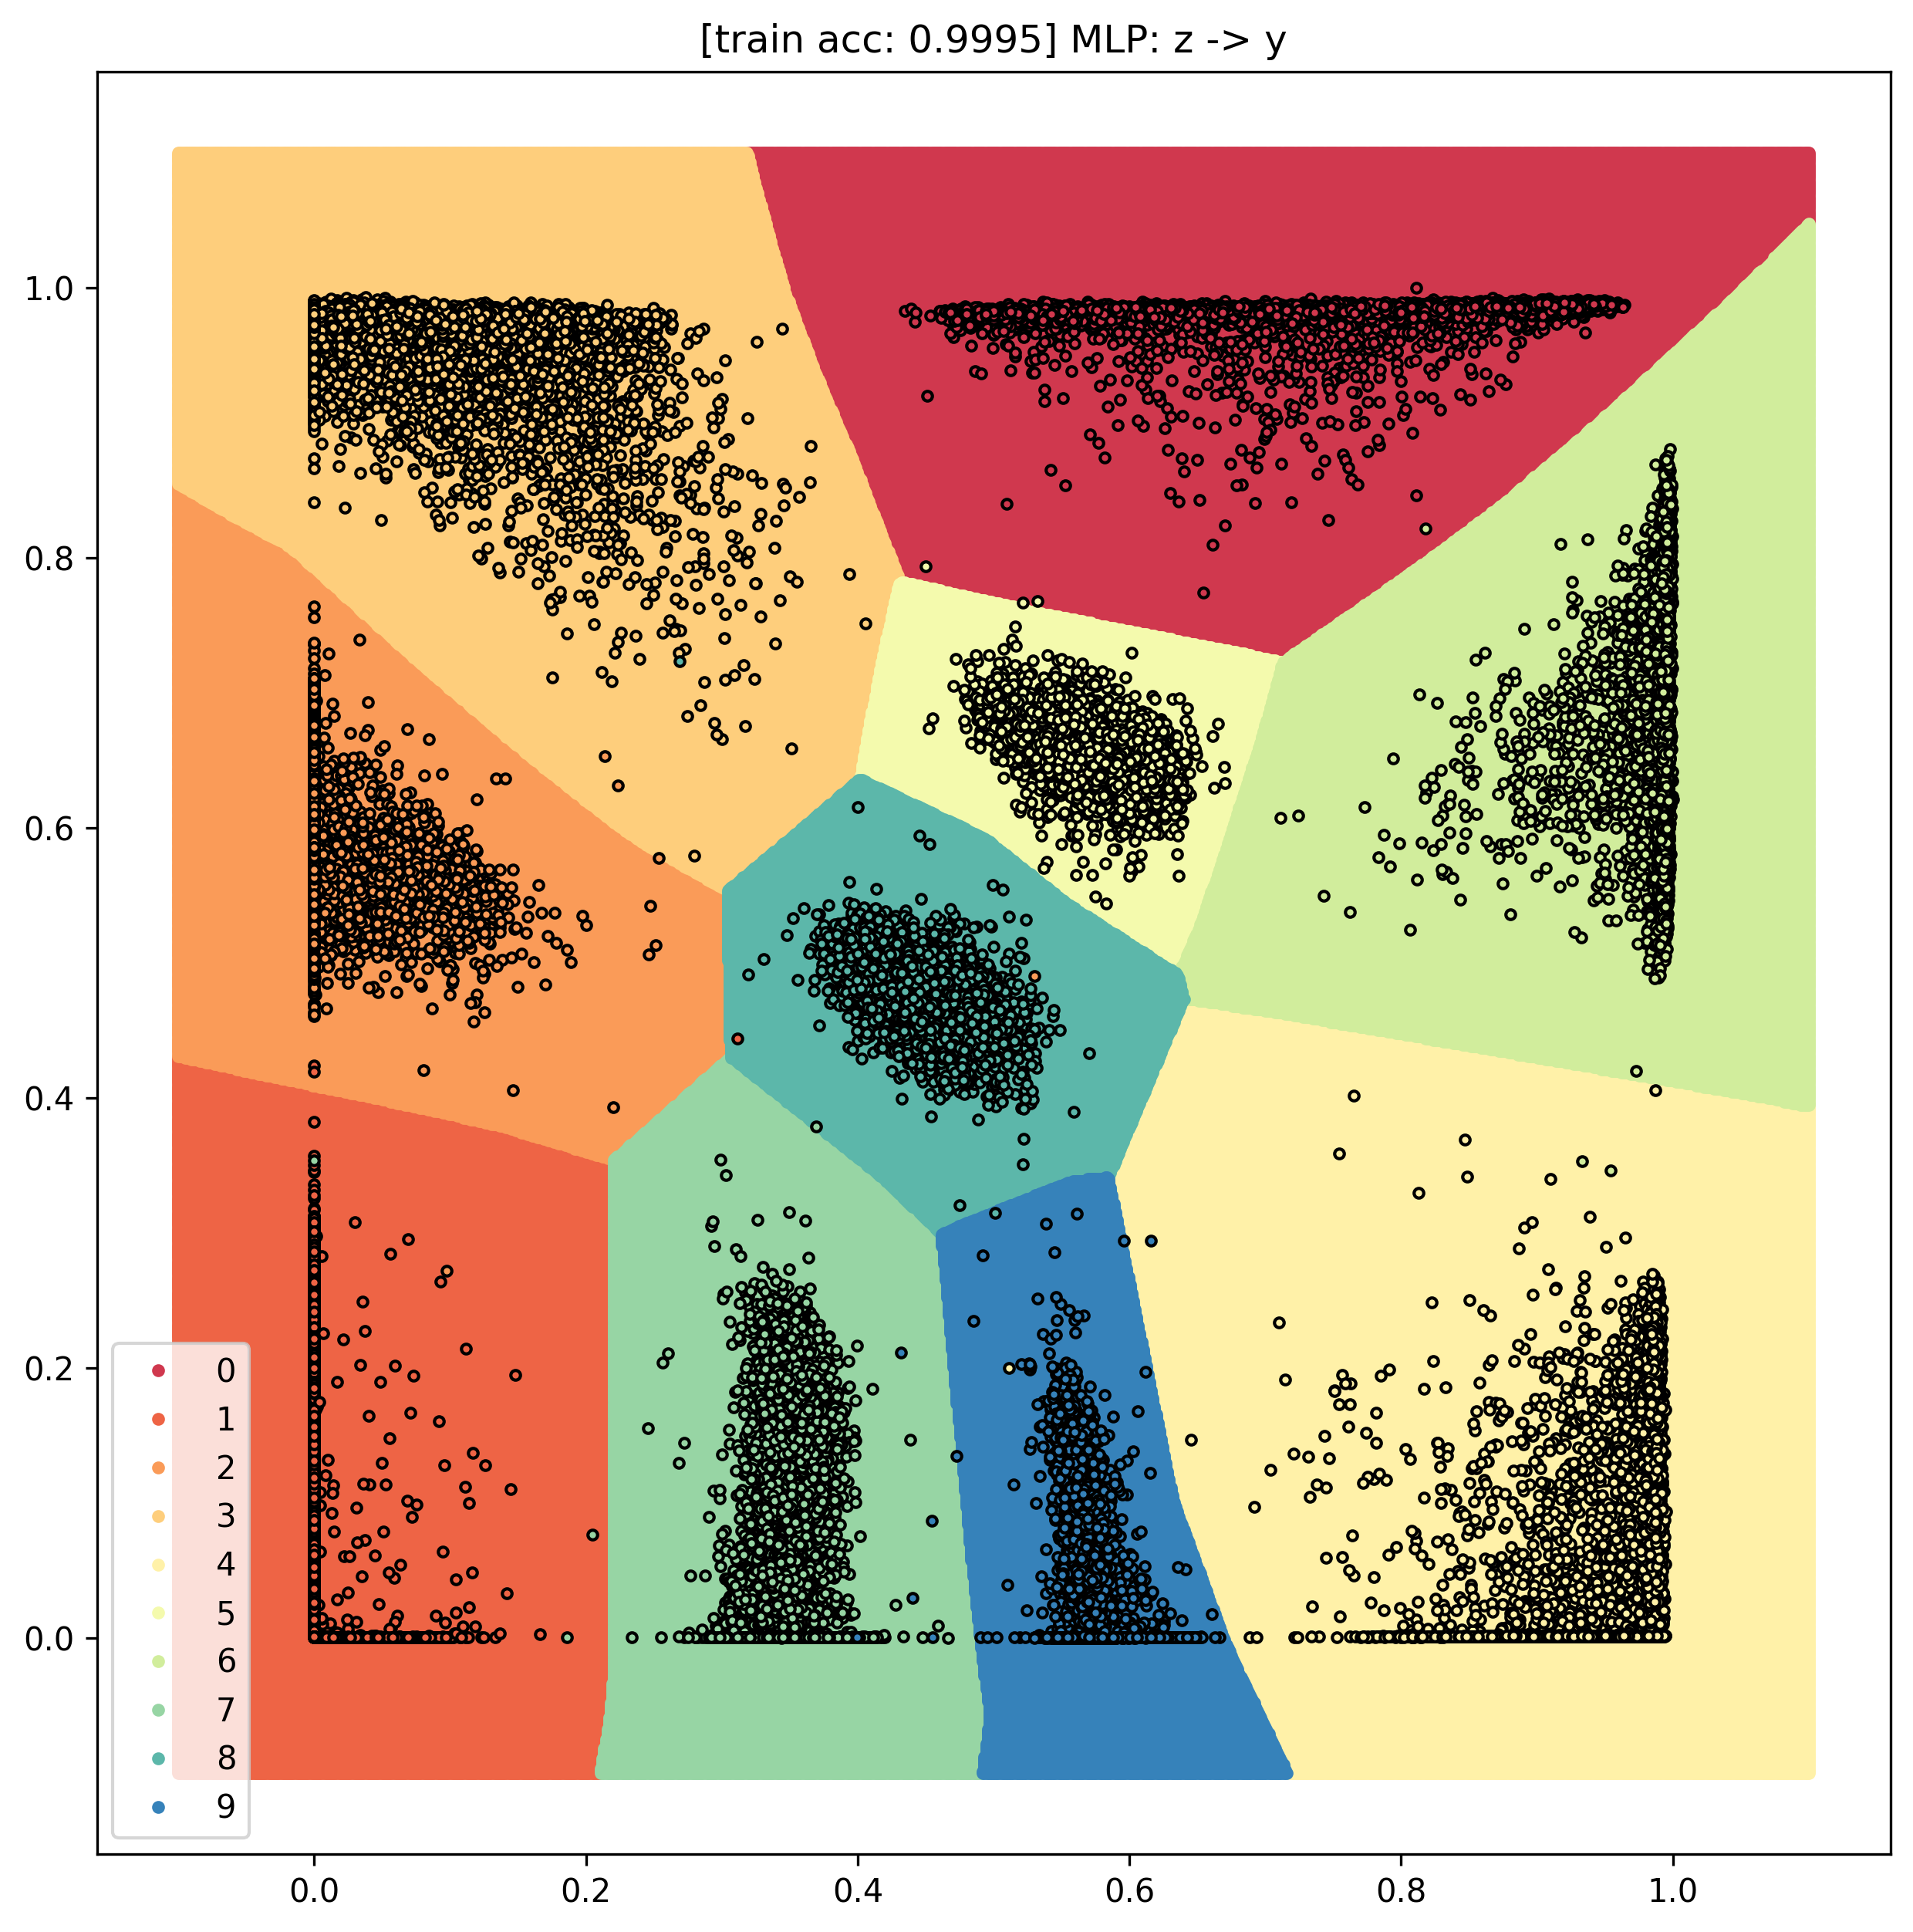

In [110]:
draw_decision(
    z_train=z_train, z_test=z_test, y_train=y_train, y_test=y_test, 
    train = True, 
    model_path="./results/231204144400/II-1/HM_weights_II-1.pt")

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 919.95it/s]


train acc: 0.9995, test acc: 0.9829


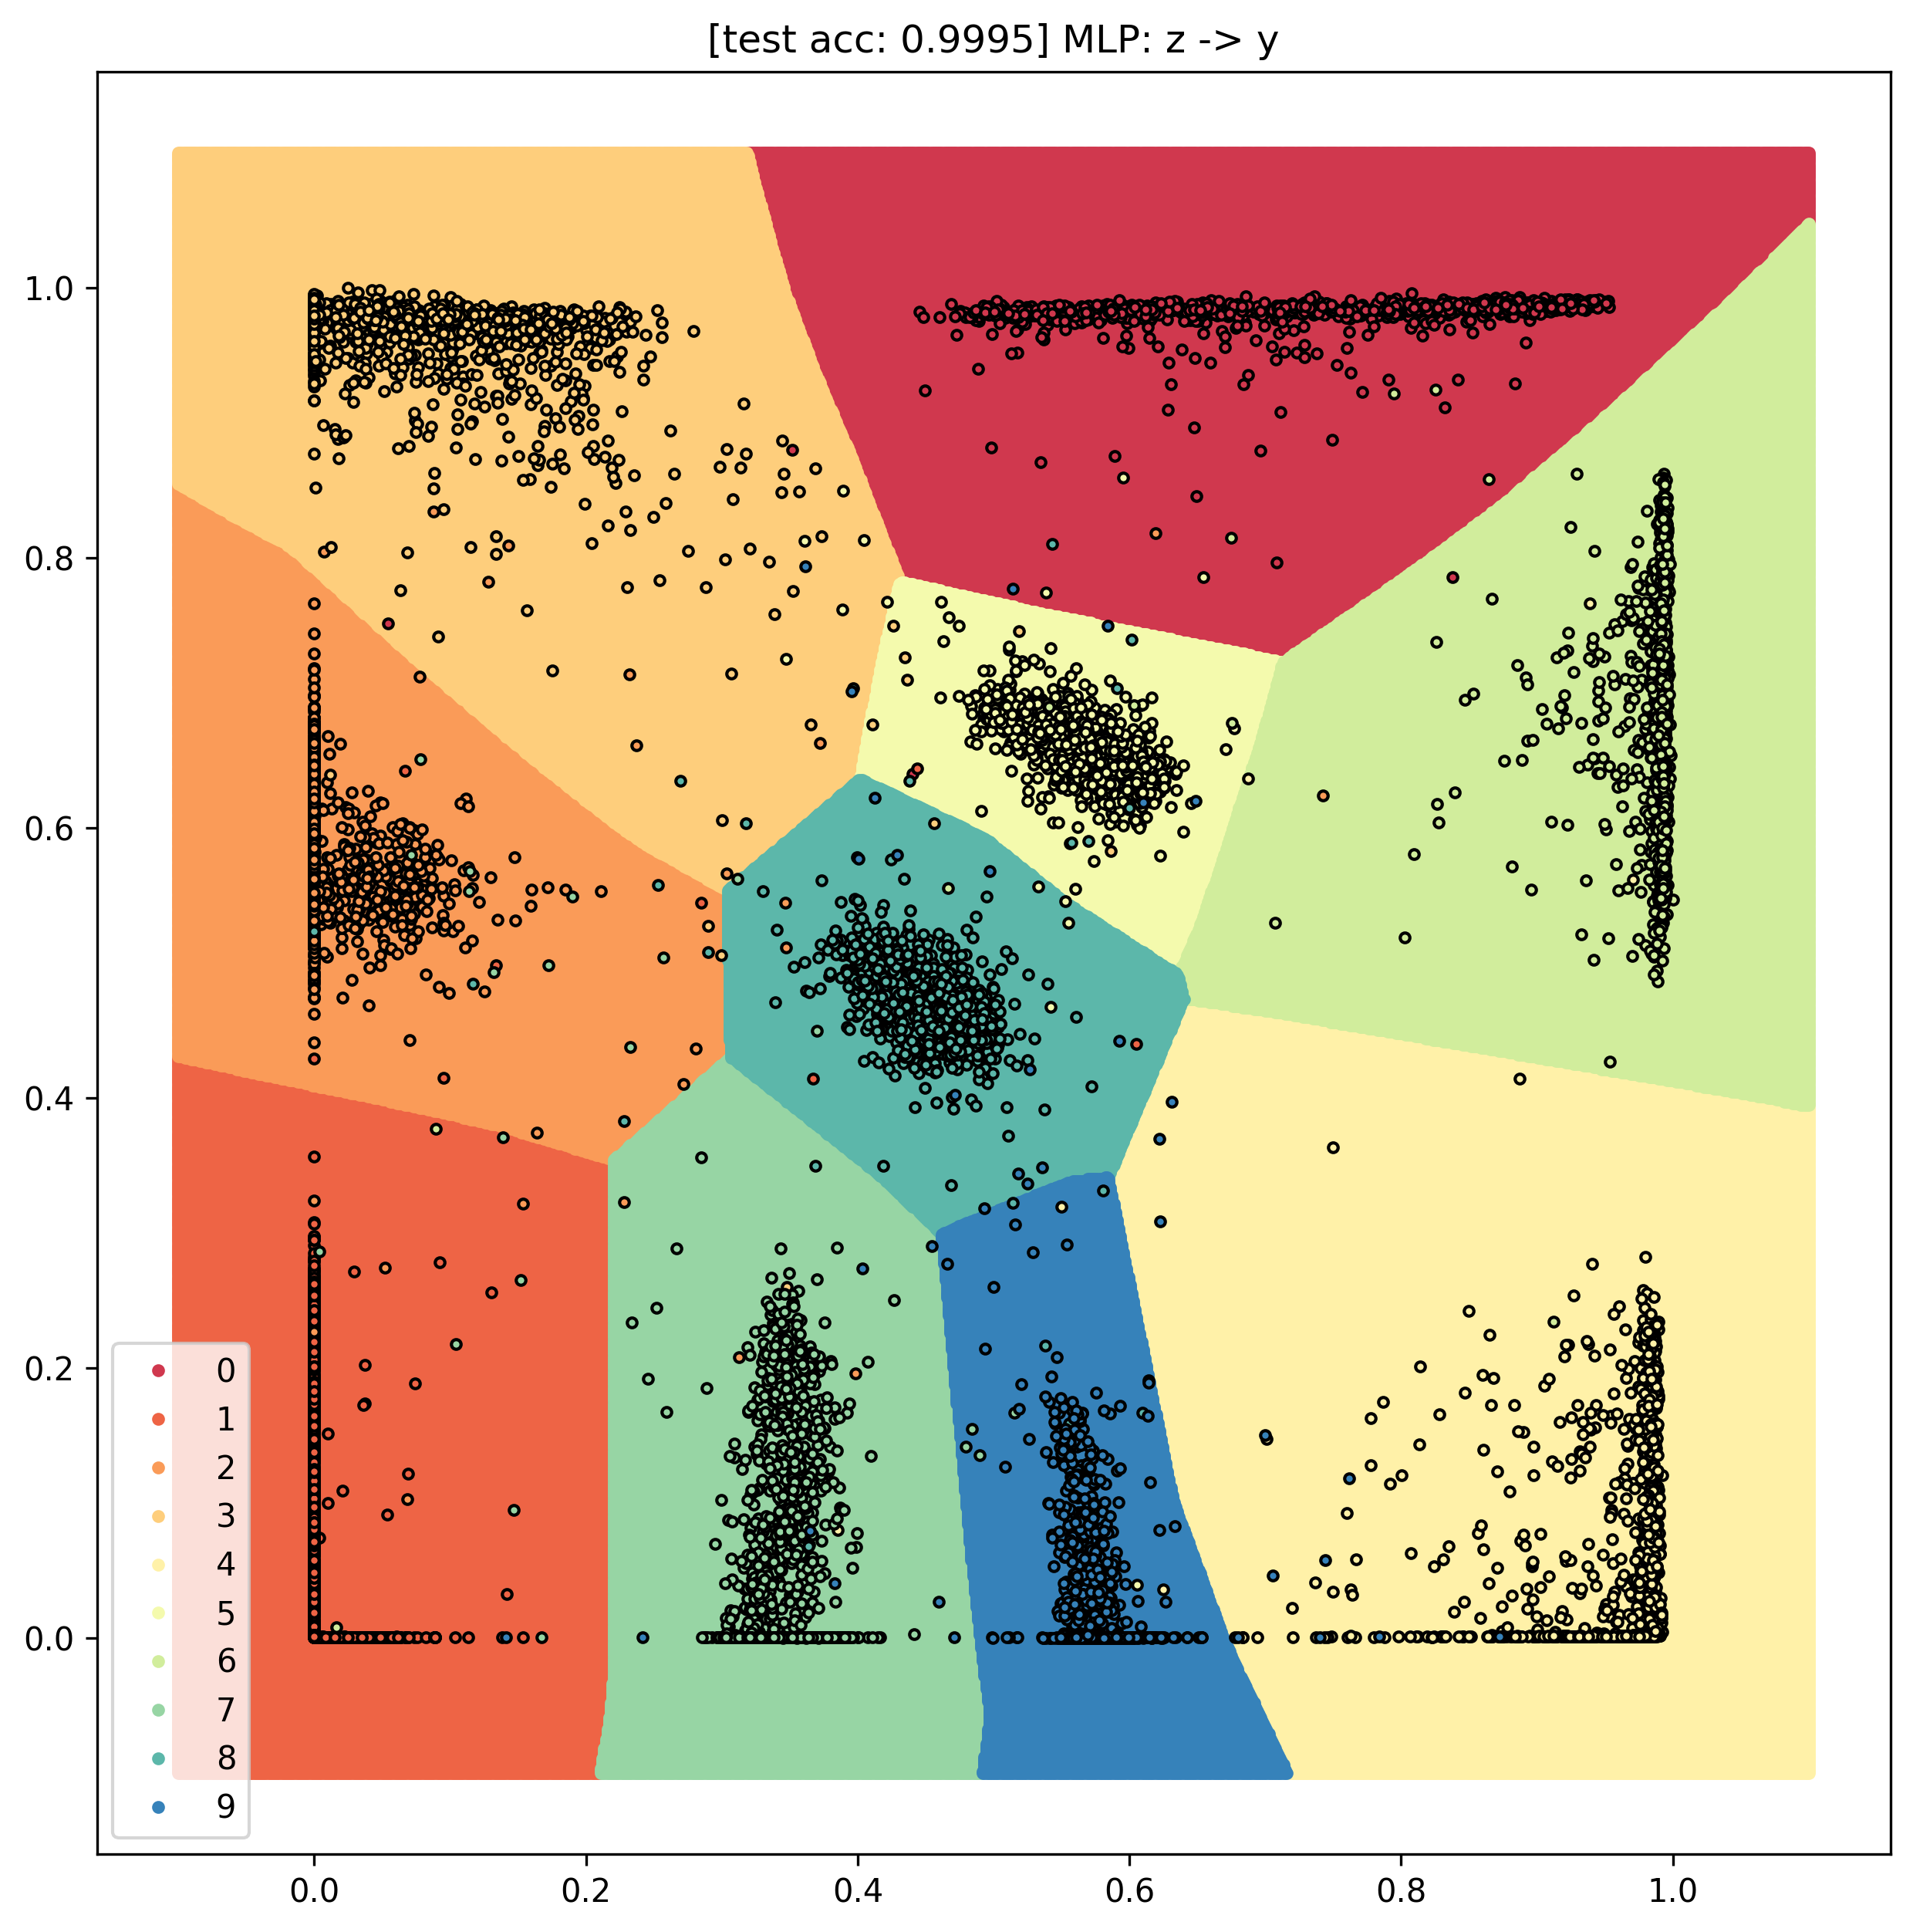

In [114]:
draw_decision(
    z_train=z_train, z_test=z_test, y_train=y_train, y_test=y_test, 
    train = False, 
    model_path="./results/231204144400/II-1/HM_weights_II-1.pt")

# 20231123

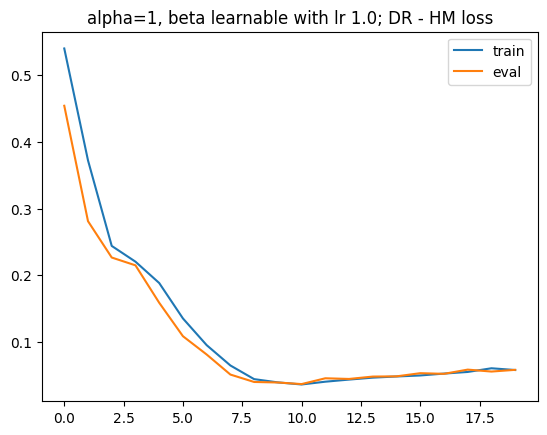

In [3]:
train_losses = torch.load("./results/231124005406/I-1/train_losses_I-1.pt")
eval_losses = torch.load("./results/231124005406/I-1/eval_losses_I-1.pt")
plt.title("alpha=1, beta learnable with lr 1.0; DR - HM loss")
plt.plot(train_losses[:, 1])
plt.plot(eval_losses[:, 1])
plt.legend(["train", "eval"])
plt.show()

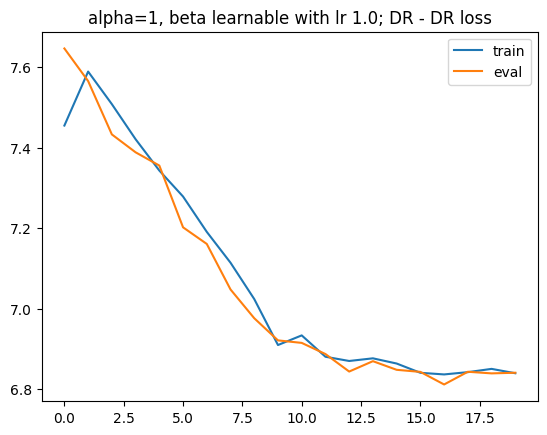

In [5]:
plt.title("alpha=1, beta learnable with lr 1.0; DR - DR loss")
plt.plot(train_losses[:, 0])
plt.plot(eval_losses[:, 0])
plt.legend(["train", "eval"])
plt.show()

# 20231122

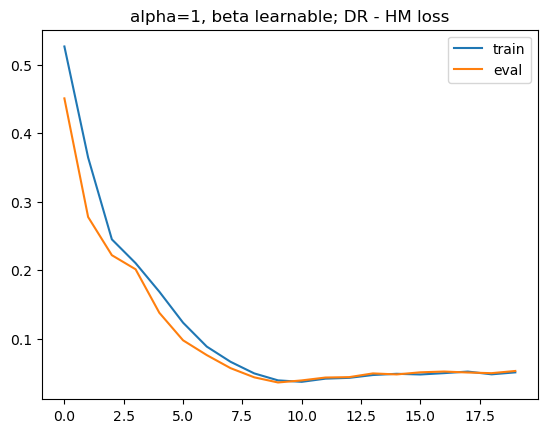

In [8]:
train_losses = torch.load("./results/231122122449/I-1/train_losses_I-1.pt")
eval_losses = torch.load("./results/231122122449/I-1/eval_losses_I-1.pt")
plt.title("alpha=1, beta learnable; DR - HM loss")
plt.plot(train_losses[:,1])
plt.plot(eval_losses[:, 1])
plt.legend(["train", "eval"])
plt.show()

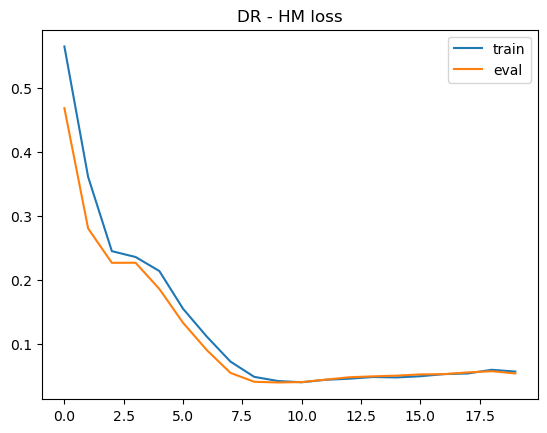

In [7]:
train_losses = torch.load("./results/231122110248/I-1/train_losses_I-1.pt")
eval_losses = torch.load("./results/231122110248/I-1/eval_losses_I-1.pt")
plt.title("DR - HM loss")
plt.plot(train_losses[:,1])
plt.plot(eval_losses[:, 1])
plt.legend(["train", "eval"])
plt.show()

# 20231016

purpose: train UMAP to learn t-SNE layout

([<matplotlib.lines.Line2D at 0x15dcb8cdc40>],
 tensor([1.3852, 0.7633, 0.4041, 0.3610, 0.3531, 0.3503, 0.3489, 0.3482, 0.3478,
         0.3475, 0.3473, 0.3472, 0.3471, 0.3470, 0.3470, 0.3469, 0.3469, 0.3469,
         0.3468, 0.3468, 0.3468, 0.3468, 0.3468, 0.3468, 0.3468, 0.3468, 0.3468,
         0.3468, 0.3468, 0.3468], dtype=torch.float64))

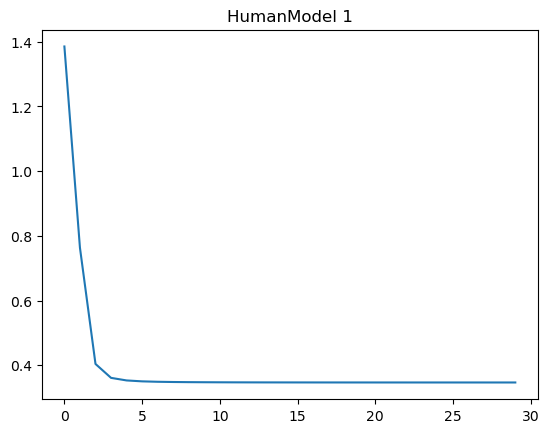

In [18]:
# II-1
train_losses = torch.load("./results/231016234028_II_1/train_losses_II_1.pt")
plt.title("HumanModel 1")
plt.plot(train_losses), train_losses

In [15]:
# I-1
train_losses = torch.load("./results/231017152222_I_1/train_losses_I_1.pt")
eval_losses = torch.load("./results/231017152222_I_1/eval_losses_I_1.pt")
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(train_losses[0][0], train_losses[0][1], train_losses[0][2]))
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(eval_losses[0][0], eval_losses[0][1], eval_losses[0][2]))

total: 0.4626, DR: 0.1158, HM: 0.3468
total: 0.5104, DR: 0.1636, HM: 0.3468


([<matplotlib.lines.Line2D at 0x15dd2643400>],
 tensor([2.2001e+00, 7.9300e-01, 5.5378e-01, 3.7979e-01, 2.0771e-01, 8.0397e-02,
         2.7406e-02, 1.2246e-02, 6.9796e-03, 4.6143e-03, 3.3392e-03, 2.5667e-03,
         2.0620e-03, 1.7128e-03, 1.4610e-03, 1.2743e-03, 1.1326e-03, 1.0235e-03,
         9.3833e-04, 8.7144e-04, 8.1870e-04, 7.7726e-04, 7.4491e-04, 7.2003e-04,
         7.0133e-04, 6.8784e-04, 6.7861e-04, 6.7285e-04, 6.6976e-04, 6.6852e-04],
        dtype=torch.float64))

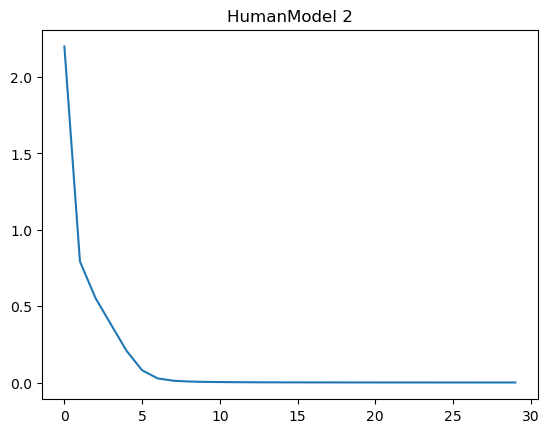

In [19]:
# II-2
# train_losses = torch.load("./results/231017155544_II_2/train_losses_II_2.pt")
train_losses = torch.load("./results/231017165347_II_2/train_losses_II_2.pt")
plt.title("HumanModel 2")
plt.plot(train_losses), train_losses

In [21]:
# I-2
# train_losses = torch.load("./results/231017160532_I_2/train_losses_I_2.pt")
# eval_losses = torch.load("./results/231017160532_I_2/eval_losses_I_2.pt")
train_losses = torch.load("./results/231017170524_I_2/train_losses_I_2.pt")
eval_losses = torch.load("./results/231017170524_I_2/eval_losses_I_2.pt")
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(train_losses[0][0], train_losses[0][1], train_losses[0][2]))
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(eval_losses[0][0], eval_losses[0][1], eval_losses[0][2]))

total: 0.1160, DR: 0.1153, HM: 0.0007
total: 0.1634, DR: 0.1627, HM: 0.0007


([<matplotlib.lines.Line2D at 0x15dd26b9550>],
 tensor([7.7016e+00, 2.3546e+00, 9.7913e-01, 4.8165e-01, 1.9009e-01, 7.9100e-02,
         4.0960e-02, 2.4689e-02, 1.6554e-02, 1.1995e-02, 9.1941e-03, 7.3537e-03,
         6.0804e-03, 5.1333e-03, 4.3444e-03, 3.7562e-03, 3.3197e-03, 2.9898e-03,
         2.7365e-03, 2.5397e-03, 2.3863e-03, 2.2666e-03, 2.1738e-03, 2.1029e-03,
         2.0500e-03, 2.0119e-03, 1.9859e-03, 1.9698e-03, 1.9612e-03, 1.9578e-03],
        dtype=torch.float64))

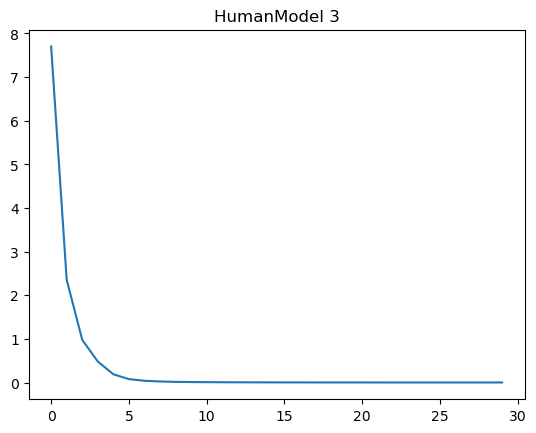

In [22]:
# II-3
train_losses = torch.load("./results/231017172646_II_3/train_losses_II_3.pt")
plt.title("HumanModel 3")
plt.plot(train_losses), train_losses

In [23]:
# I-3
train_losses = torch.load("./results/231017173718_I_3/train_losses_I_3.pt")
eval_losses = torch.load("./results/231017173718_I_3/eval_losses_I_3.pt")
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(train_losses[0][0], train_losses[0][1], train_losses[0][2]))
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(eval_losses[0][0], eval_losses[0][1], eval_losses[0][2]))

total: 0.1170, DR: 0.1149, HM: 0.0021
total: 0.1628, DR: 0.1606, HM: 0.0022


# evaluation

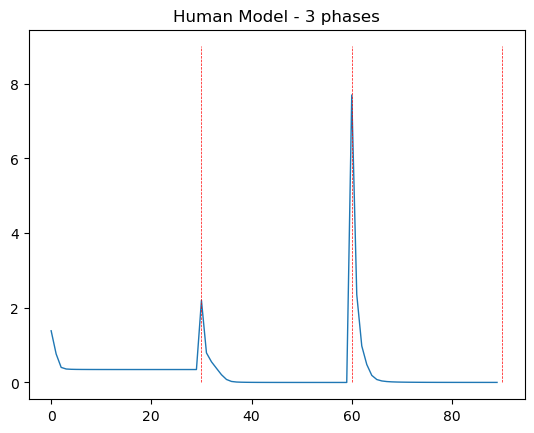

In [39]:
# II
train_losses1 = torch.load("./results/231016234028_II_1/train_losses_II_1.pt")
train_losses2 = torch.load("./results/231017165347_II_2/train_losses_II_2.pt")
train_losses3 = torch.load("./results/231017172646_II_3/train_losses_II_3.pt")

HM_loss_li = torch.hstack([train_losses1, train_losses2, train_losses3])

plt.plot(HM_loss_li, linewidth=1)
plt.vlines([30, 60, 90], 0, 9, linestyles='dashed', colors='red', linewidth=0.5)
plt.title("Human Model - 3 phases")
plt.show()

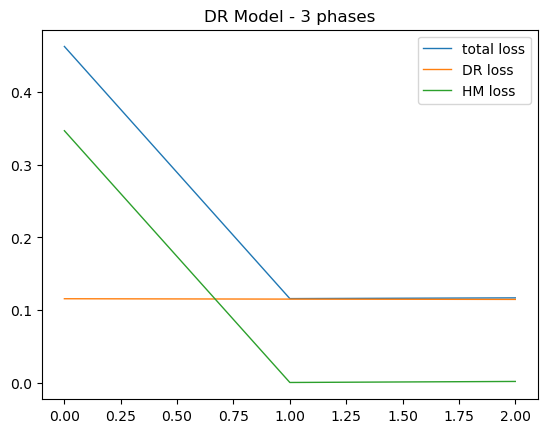

In [55]:
# I
train_losses1 = torch.load("./results/231017152222_I_1/train_losses_I_1.pt")
train_losses2 = torch.load("./results/231017170524_I_2/train_losses_I_2.pt")
train_losses3 = torch.load("./results/231017173718_I_3/train_losses_I_3.pt")

DR_total_loss_li = torch.hstack([train_losses1[0][0], train_losses2[0][0], train_losses3[0][0]])
DR_DR_loss_li = torch.hstack([train_losses1[0][1], train_losses2[0][1], train_losses3[0][1]])
DR_HM_loss_li = torch.hstack([train_losses1[0][2], train_losses2[0][2], train_losses3[0][2]])

plt.plot(DR_total_loss_li, linewidth=1)
plt.plot(DR_DR_loss_li, linewidth=1)
plt.plot(DR_HM_loss_li, linewidth=1)
plt.legend(["total loss", "DR loss", "HM loss"])
plt.title("DR Model - 3 phases")
plt.show()

# indicating vector

In [47]:
hm1 = torch.load("./results/231024141732/II-1/HM_weights_II-1.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.sigmoid(hm1["user_weights"].view(-1))

(tensor([ 0.0329, -0.0247,  0.0199, -0.0001, -0.0365, -0.0396, -0.0339, -0.0047,
         -0.0321], device='cuda:0'),
 tensor([-0.0027,  0.0297,  0.0139, -0.0012,  0.0022,  0.0023,  0.0092,  0.0147,
         -0.0002], device='cuda:0'),
 tensor([0.5688, 0.6413, 0.5135, 0.6444, 0.6192, 0.7000, 0.6304, 0.6092, 0.7306],
        device='cuda:0'))

In [53]:
hm1 = torch.load("./results/231024154957/II-1/HM_weights_II-1.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.sigmoid(hm1["user_weights"].view(-1))

(tensor([-0.0469, -0.0596, -0.0399, -0.0079,  0.0570,  0.0216, -0.0578, -0.0480,
          0.0410], device='cuda:0'),
 tensor([-0.0003,  0.0020, -0.0113, -0.0033,  0.0003, -0.0048, -0.0039, -0.0174,
         -0.0023], device='cuda:0'),
 tensor([0.5002, 0.5009, 0.4974, 0.4992, 0.5005, 0.4989, 0.4995, 0.4959, 0.4997],
        device='cuda:0'))

In [52]:
# hm1 = torch.load("./results/231024161015/II-1/HM_weights_II-1.pt")
# hm1["mu"].view(-1), hm1["logvar"].view(-1), F.sigmoid(hm1["user_weights"].view(-1))
# always 0.5

In [58]:
hm1 = torch.load("./results/231024162648/II-1/HM_weights_II-1.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.sigmoid(hm1["user_weights"].view(-1))

(tensor([ 0.0083, -0.0094,  0.0071,  0.0145,  0.0238,  0.0447, -0.0254,  0.0096,
          0.0086], device='cuda:0'),
 tensor([ 0.0028, -0.0105, -0.0033,  0.0003,  0.0011, -0.0004, -0.0053, -0.0028,
         -0.0022], device='cuda:0'),
 tensor([0.5007, 0.4974, 0.4992, 0.5001, 0.5003, 0.5001, 0.4987, 0.4993, 0.4995],
        device='cuda:0'))

In [81]:
hm1 = torch.load("./results/231024164739/II-1/HM_weights_II-1.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.sigmoid(hm1["user_weights"].view(-1))

(tensor([-0.0062, -0.0664,  0.0349,  0.0428,  0.0568, -0.0012,  0.0195, -0.0358,
          0.0466], device='cuda:0'),
 tensor([-0.0041, -0.0197,  0.0062,  0.0128,  0.0142, -0.0036, -0.0021, -0.0167,
          0.0122], device='cuda:0'),
 tensor([0.4990, 0.4955, 0.5017, 0.5034, 0.5038, 0.4991, 0.4995, 0.4959, 0.5033],
        device='cuda:0'))

In [83]:
hm1 = torch.load("./results/231024171155/II-1/HM_weights_II-1.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.sigmoid(hm1["user_weights"].view(-1))

(tensor([ 0.0542, -0.0807, -0.0494, -0.0072,  0.0110, -0.0546, -0.0942,  0.0296,
          0.0409], device='cuda:0'),
 tensor([-0.0030,  0.0198,  0.0196, -0.0063, -0.0016, -0.0051,  0.0314, -0.0039,
         -0.0036], device='cuda:0'),
 tensor([0.4996, 0.4959, 0.4962, 0.4999, 0.5000, 0.5002, 0.4948, 0.5000, 0.4998],
        device='cuda:0'))

In [164]:
hm1 = torch.load("./results/231024172445/II-1/HM_weights_II-1.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.tanh(hm1["user_weights"].view(-1))

(tensor([ 0.0929,  0.0603,  0.0137, -0.0407,  0.0870, -0.0034, -0.0997,  0.0169,
          0.0905], device='cuda:0'),
 tensor([ 0.0035,  0.0024, -0.0019,  0.0008,  0.0018, -0.0007,  0.0005, -0.0018,
          0.0052], device='cuda:0'),
 tensor([ 0.0069,  0.0040, -0.0005, -0.0040,  0.0064,  0.0010,  0.0051,  0.0002,
          0.0097], device='cuda:0'))

In [178]:
hm1 = torch.load("./results/231024172445/II-2/HM_weights_II-2.pt")
hm1["mu"].view(-1), hm1["logvar"].view(-1), F.tanh(hm1["user_weights"].view(-1))

(tensor([ 0.1165,  0.0746,  0.0573, -0.0494,  0.1028,  0.0675, -0.1250, -0.0555,
          0.1187], device='cuda:0'),
 tensor([ 5.1014e-03,  2.0413e-03, -5.0893e-04,  8.8849e-05,  5.6451e-04,
          9.0908e-04,  3.4753e-03,  1.3708e-03,  4.7573e-03], device='cuda:0'),
 tensor([ 0.0103,  0.0047,  0.0029, -0.0038,  0.0068, -0.0059,  0.0098,  0.0082,
          0.0121], device='cuda:0'))

In [179]:
d = hm1["mu"].view(-1)
w = F.tanh(hm1["user_weights"].view(-1))
d, w, d*w

(tensor([ 0.1165,  0.0746,  0.0573, -0.0494,  0.1028,  0.0675, -0.1250, -0.0555,
          0.1187], device='cuda:0'),
 tensor([ 0.0103,  0.0047,  0.0029, -0.0038,  0.0068, -0.0059,  0.0098,  0.0082,
          0.0121], device='cuda:0'),
 tensor([ 0.0012,  0.0003,  0.0002,  0.0002,  0.0007, -0.0004, -0.0012, -0.0005,
          0.0014], device='cuda:0'))

In [180]:
def get_weights(x):
    x = x.view(-1)

    neg = F.tanh(x) < 0
    neg = neg.type(torch.int64)

    # pos = F.tanh(x) > 0
    # pos = pos.type(torch.int64)
    # pos *= -1

    # return neg+pos

    return neg

get_weights(d*w)

tensor([0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')

In [167]:
hm1["user_weights"].view(-1), F.softmax(hm1["user_weights"].view(-1)/0.01)

(tensor([ 0.0069,  0.0040, -0.0005, -0.0040,  0.0064,  0.0010,  0.0051,  0.0002,
          0.0097], device='cuda:0'),
 tensor([0.1484, 0.1111, 0.0712, 0.0498, 0.1408, 0.0819, 0.1244, 0.0763, 0.1961],
        device='cuda:0'))

In [172]:
loss_w = get_weights(hm1["user_weights"])
loss_w

tensor([-1, -1,  1,  1, -1, -1, -1, -1, -1], device='cuda:0')

In [154]:
hm1["user_weights"].view(-1)

tensor([ 0.0069,  0.0040, -0.0005, -0.0040,  0.0064,  0.0010,  0.0051,  0.0002,
         0.0097], device='cuda:0')

In [140]:
F.tanh(hm1["user_weights"]).view(-1)

tensor([ 0.0069,  0.0040, -0.0005, -0.0040,  0.0064,  0.0010,  0.0051,  0.0002,
         0.0097], device='cuda:0')

In [125]:
hm1["mu"].view(-1) * F.tanh(hm1["user_weights"].view(-1))

tensor([ 6.4018e-04,  2.4107e-04, -6.1676e-06,  1.6409e-04,  5.5386e-04,
        -3.2207e-06, -5.1099e-04,  3.9920e-06,  8.7582e-04], device='cuda:0')

In [124]:
F.softmax(hm1["mu"].view(-1) * F.tanh(hm1["user_weights"].view(-1)) / 0.001)

tensor([0.1570, 0.1053, 0.0823, 0.0975, 0.1440, 0.0825, 0.0496, 0.0831, 0.1987],
       device='cuda:0')

In [80]:
hm1["mu"].view(-1) * F.sigmoid(hm1["user_weights"].view(-1))

tensor([ 0.0271, -0.0400, -0.0245, -0.0036,  0.0055, -0.0273, -0.0466,  0.0148,
         0.0205], device='cuda:0')

In [ ]:
HM = HumanModel(cnn_layers=[1,1,1,1], metric_num=9, device='cuda')
HM.load_state_dict(hm3)

# for p in HM.parameters():
#     break
# p.name, p.data

# 20231024

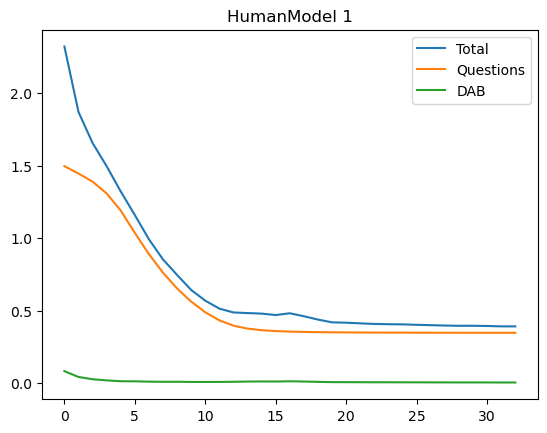

In [134]:
# II-1
train_losses = torch.load("./results/231024172445/II-1/train_losses_II-1.pt")
plt.title("HumanModel 1")
plt.plot([i[0] for i in train_losses])
plt.plot([i[1] for i in train_losses])
plt.plot([i[2] for i in train_losses])

plt.legend(["Total", "Questions", "DAB"])

In [175]:
# # I-1
# train_losses = torch.load("./results/231024172445/I-1/train_losses_I-1.pt")
# eval_losses = torch.load("./results/231024172445/I-1/eval_losses_I-1.pt")
# print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(train_losses[0][0], train_losses[0][1], train_losses[0][2]))
# print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(eval_losses[0][0], eval_losses[0][1], eval_losses[0][2]))

# I-1
train_losses = torch.load("./results/231024172445/I-1/train_losses_I-1.pt")
eval_losses = torch.load("./results/231024172445/I-1/eval_losses_I-1.pt")
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(train_losses[0][0], train_losses[0][1], train_losses[0][2]))
print("total: {:.4f}, DR: {:.4f}, HM: {:.4f}".format(eval_losses[0][0], eval_losses[0][1], eval_losses[0][2]))

total: 0.6237, DR: 0.1315, HM: 0.3474
total: 0.5183, DR: 0.1708, HM: 0.3474


## evaluation

# UMAP-tSNE Scagnostics

In [112]:
z1 = np.load("./tsne_data_reducted_normalised.npy")
all_scags1 = scagnostics.compute(z1[:, 0], z1[:, 1])
all_scags1 = torch.Tensor(list(all_scags1.values()))
all_scags1

tensor([0.0000, 0.5472, 0.0030, 0.0210, 0.0036, 0.6093, 0.3681, 0.3467, 0.0015])

In [113]:
z2 = np.load("./umap_data_reducted_normalised.npy")
all_scags2 = scagnostics.compute(z2[:, 0], z2[:, 1])
all_scags2 = torch.Tensor(list(all_scags2.values()))
all_scags2

tensor([0.0598, 0.6109, 0.0931, 0.0213, 0.0102, 0.3027, 0.6767, 0.4001, 0.0267])

differs mainly on convex and skinny

# function

In [59]:
def draw_curves_I(path="./results/231031212002/", phase="I-1"):

    train_losses = torch.load(os.path.join(path, phase, "train_losses_{}.pt".format(phase)))
    eval_losses = torch.load(os.path.join(path, phase, "eval_losses_{}.pt".format(phase)))

    plt.title("DR {}".format(phase))

    plt.plot([i[0] for i in train_losses], c='red')
    plt.plot([i[0] for i in eval_losses], c='red', ls='--')

    plt.plot([i[1] for i in train_losses], c='orange')
    plt.plot([i[1] for i in eval_losses], c='orange', ls='--')

    plt.plot([i[2] for i in train_losses], c='green')
    plt.plot([i[2] for i in eval_losses], c='green', ls='--')

    plt.plot([i[3] for i in train_losses], c='blue')
    plt.plot([i[3] for i in eval_losses], c='blue', ls='--')

    plt.legend(["train_total", "eval_total", "train_DR", "eval_DR", "train_HM", "eval_HM", "train_metrics", "eval_metrics"])
    plt.show()


def draw_curves_II(path="./results/231031212002/", phase="II-1"):

    train_losses = torch.load(os.path.join(path, phase, "train_losses_{}.pt".format(phase)))
    eval_losses = torch.load(os.path.join(path, phase, "test_losses_{}.pt".format(phase)))

    print(len(eval_losses), eval_losses)

    plt.title("HM {}".format(phase))

    # plt.plot([i[0] for i in train_losses], c='red')
    plt.plot([i[1] for i in train_losses], c='red')
    plt.plot([i[2] for i in train_losses], c='orange')

    plt.plot(eval_losses, c='green', ls='--')

    # plt.legend(["train_total", "train_Question", "train_DAB", "eval_Question"])
    plt.legend(["train_Question", "train_DAB", "eval_Question"])
    plt.show()

# 20231031

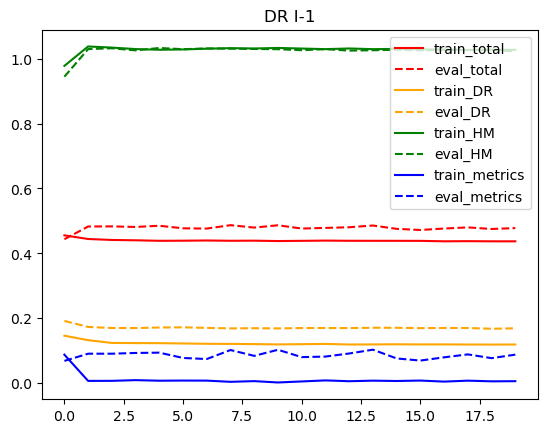

In [60]:
draw_curves_I(path="./results/231031212002/", phase="I-1")

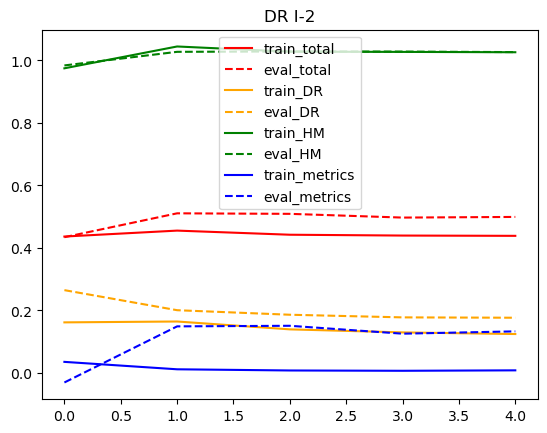

In [61]:
draw_curves_I(path="./results/231031212002/", phase="I-2")

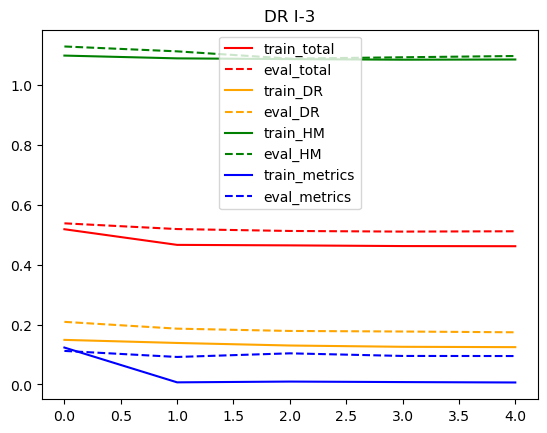

In [62]:
draw_curves_I(path="./results/231031212002/", phase="I-3")

5 tensor([3.0901, 3.2818, 3.4341, 3.5275, 3.5559], dtype=torch.float64)


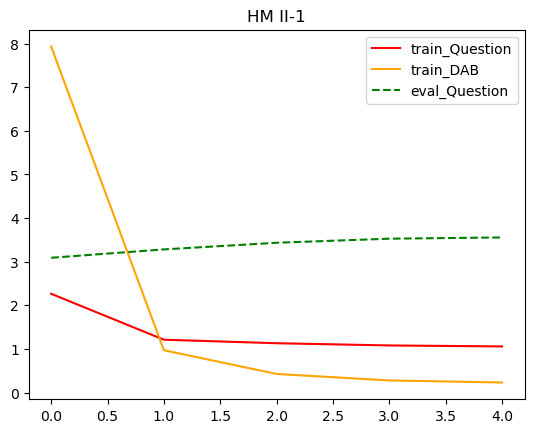

In [63]:
draw_curves_II(path="./results/231031212002/", phase="II-1")

5 tensor([3.1511, 3.3066, 3.4890, 3.6020, 3.6353], dtype=torch.float64)


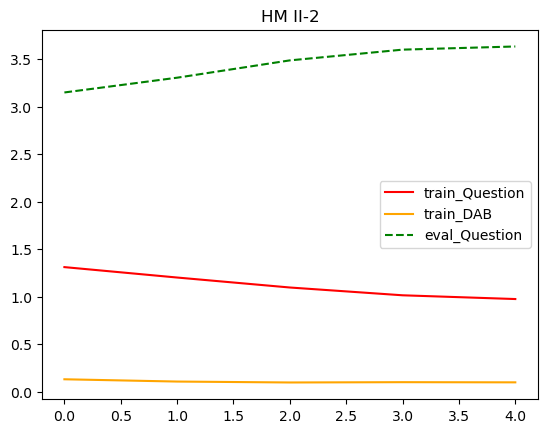

In [64]:
draw_curves_II(path="./results/231031212002/", phase="II-2")

5 tensor([3.0201, 3.0416, 3.0421, 3.0873, 3.1064], dtype=torch.float64)


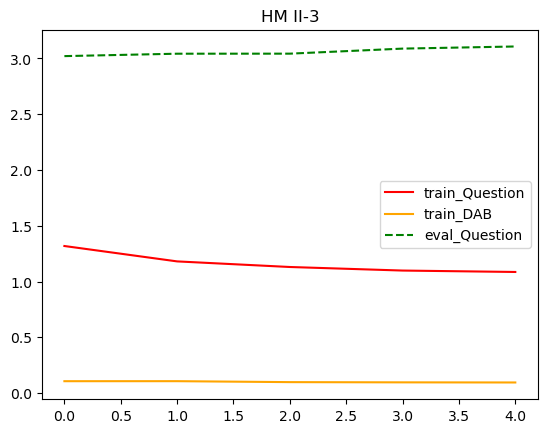

In [65]:
draw_curves_II(path="./results/231031212002/", phase="II-3")